In [1]:
%matplotlib inline

## [Data Imputation of Missing Values](https://scikit-learn.org/stable/modules/impute.html)
- scikit estimators assume all array values are numerical and have meaning.

## [Univariate Features](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)
- Missing values can be replaced with a constant or a statistical value.

In [2]:
import numpy as np
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values = np.nan, 
                    strategy       = 'mean')

imp.fit([[1,      2], 
         [np.nan, 3], 
         [7,      6]])

X =     [[np.nan, 2], 
         [6, np.nan], 
         [7,      6]]

print(imp.transform(X))

[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


- Sparse matrices are supported.

In [3]:
import scipy.sparse as sp
X   = sp.csc_matrix([[1,  2], 
                     [0, -1], 
                     [8,  4]])
imp = SimpleImputer(missing_values=-1, strategy='mean')
imp.fit(X)

X_test = sp.csc_matrix([[-1,  2], 
                        [ 6, -1], 
                        [ 7,  6]])
print(imp.transform(X_test).toarray())

[[3. 2.]
 [6. 3.]
 [7. 6.]]


- Category data (strings or Pandas categoricals) is supported when using ````most_frequent```` or ```'constant'``` strategies.

In [4]:
import pandas as pd
df = pd.DataFrame([["a",    "x"],
                   [np.nan, "y"],
                   ["a", np.nan],
                   ["b",    "y"]], dtype="category")

imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df))

[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


## [Multivariate Feature Imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)
- Model each feature with missing data as a function of other features.
- Uses an iterative, round-robin regression algorithm.
- *Still experimental at this point* (2020/06/15).

In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute       import IterativeImputer

imp = IterativeImputer(max_iter=10, 
                       random_state=0)
imp.fit([[1,      2], 
         [3,      6], 
         [4,      8], 
         [np.nan, 3], 
         [7, np.nan]])

X_test = [[np.nan, 2], 
          [6, np.nan], 
          [np.nan, 6]]

# the model learns that the second feature is double the first
print(np.round(imp.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


## Example: [Iterative Imputer variants](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py)
- Compares estimators for missing feature imputation:
    - Bayesian Ridge (regularized, linear regression)
    - Decision Tree Regressor (non-linear regression)
    - Extra Trees Regressor (similar to missForest in R)
    - K Neighbors Regressor (similar to KNN)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [7]:
N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator    = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

# Add a single missing value to each row
X_missing        = X_full.copy()
y_missing        = y_full
missing_samples  = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan


In [8]:
# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)


/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bjpcjp/.local/lib/python

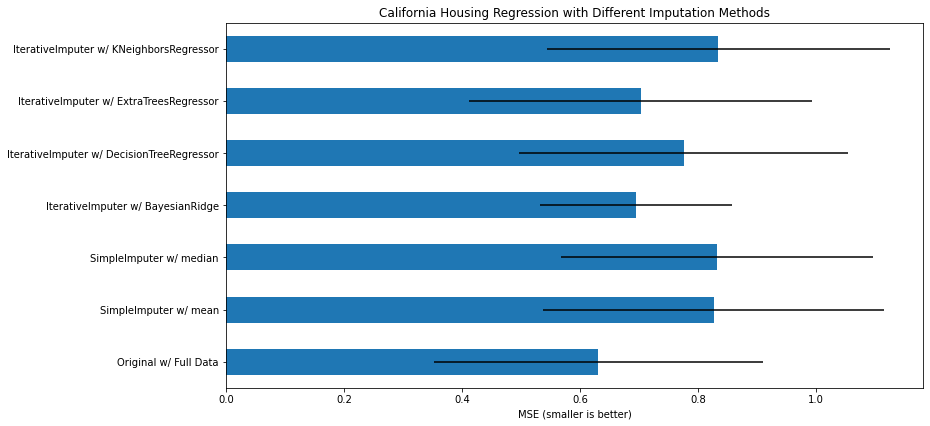

In [9]:
# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('California Housing Regression with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

## Multiple vs Single Imputation
- Common ML practice to subject multiple imputations to an analysis pipeline.
- [Iterative Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) returns a single imputation, not multiple ones. It can be used for multiple imputations by applying it repeatedly to the same dataset with different random seeds and using ```sample_posterior=True```.

## [Nearest Neighbor Imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer)
- Fills missing values using a KNN algorithm.
- A Euclidean distance metric is the default. (```nan_euclidean_distances```)

In [10]:
import numpy as np
from sklearn.impute import KNNImputer

nan = np.nan
X   = [[  1, 2, nan], 
       [  3, 4,   3], 
       [nan, 6,   5], 
       [  8, 8,   7]]

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

## [Marking Imputed Values](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html#sklearn.impute.MissingIndicator)
- Transforms a dataset into a binary matrix indicating where missing values are located.
- ```NaN``` is the default missing value placeholder. ```missing_values``` can use other placeholders such as integers. Below: -1 is used as a missing value.

In [11]:
from sklearn.impute import MissingIndicator
X = np.array([[-1, -1, 1, 3],
              [4, -1, 0, -1],
              [8, -1, 1, 0]])

indicator                = MissingIndicator(missing_values=-1)
mask_missing_values_only = indicator.fit_transform(X)
mask_missing_values_only

array([[ True,  True, False],
       [False,  True,  True],
       [False,  True, False]])

- ```features``` is used to choose the features for mask construction. By default it uses ```'missing-only'```.

In [12]:
indicator.features_

array([0, 1, 3])

- ```features``` can be set to ```'all'``` to return all features re